# 2K dataset analysis

SAM definitions for ladder

 - `msotgia_v09_89_01_01p03_down_vtx_both_ifdh_reco_cheated_2D`
 - `msotgia_v09_89_01_01p03_down_vtx_both_ifdh_reco_cheated_2D_vtx`
 - `msotgia_v09_89_01_01p03_down_vtx_both_ifdh_reco_cheated_2D_vtx_3D`
 - `msotgia_v09_89_01_01p03_down_vtx_both_ifdh_reco_cheated_2D_vtx_3D_Nu`
 - `msotgia_v09_89_01_01p03_down_vtx_both_ifdh_reco_cheated_2D_vtx_3D_Nu_mva`

SAM definition for singles

 - `msotgia_v09_89_01_01p03_down_vtx_both_ifdh_reco_cheated_vtx`
 - `msotgia_v09_89_01_01p03_down_vtx_both_ifdh_reco_cheated_mva`
 - `msotgia_v09_89_01_01p03_down_vtx_both_ifdh_reco_cheated_vtx_selection`

SAM nominal `msotgia_v09_89_01_01p03_down_vtx_both_ifdh_reco_nominal`

In [155]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import ultraplot as plot 


import uproot
import mplhep as hep
import hist
import hist.intervals
import hist.plot

plot.rc['figure.facecolor'] = 'none'
plot.rc['savefig.facecolor'] = 'none'
plot.rc['legend.frameon'] = False
plot.rc['axes.autolimit_mode'] = 'data'

plot.rc['cmap.levels'] = 4


class Analysis:
    def __init__(self, data, binning, tree_bases=['reco_true_{}', 'reco_{}', 'true_{}']):
        self.binning = binning
        self.data = data

        self.reco_true_base_string, self.reco_base_string, self.true_base_string = tree_bases

    def efficiency(self, tree_name: str, variable: str = 'true_E'):

        reco_true = self.data[self.reco_true_base_string.format(tree_name)].arrays(library='pd')
        true = self.data[self.true_base_string.format(tree_name)].arrays(library='pd')

        common = pd.merge(reco_true.event, true.event, on='event')
        
        reco_true_H = hist.Hist(self.binning).fill(reco_true[reco_true.event.isin(common.event)][variable].values)
        true_H = hist.Hist(self.binning).fill(true[true.event.isin(common.event)][variable].values)

        reco_true_values = reco_true_H.values()
        true_values = true_H.values()
        
        with np.errstate(divide="ignore", invalid="ignore"):
            efficiency = reco_true_values/true_values
            efficiency_uncertainty = hist.intervals.ratio_uncertainty(
                reco_true_values, true_values, 'efficiency'
            )
        
        return efficiency, efficiency_uncertainty
    
    def purity(self, tree_name: str, variable: str = 'true_E'):
        
        reco_true = self.data[self.reco_true_base_string.format(tree_name)].arrays(library='pd')
        reco = self.data[self.reco_base_string.format(tree_name)].arrays(library='pd')

        common = pd.merge(reco_true.event, reco.event, on='event')
        
        reco_true_H = hist.Hist(self.binning).fill(reco_true[reco_true.event.isin(common.event)][variable].values)
        reco_H = hist.Hist(self.binning).fill(reco[reco.event.isin(common.event)][variable].values)

        reco_true_values = reco_true_H.values()
        reco_values = reco_H.values()
        
        with np.errstate(divide="ignore", invalid="ignore"):
            purity = reco_true_values/reco_values
            purity_uncertainty = hist.intervals.ratio_uncertainty(
                reco_true_values, reco_values, 'efficiency'
            )
        
        return purity, purity_uncertainty

    def spectra(self, tree_name: str, variable: str = 'true_E'):
        
        reco_true = self.data[self.reco_true_base_string.format(tree_name)].arrays(library='pd')
        reco = self.data[self.reco_base_string.format(tree_name)].arrays(library='pd')
        true = self.data[self.true_base_string.format(tree_name)].arrays(library='pd')

        common = pd.merge(reco_true.event, reco.event, on='event')
        common = pd.merge(common.event, true.event, on='event')

        reco_true_H = hist.Hist(self.binning).fill(reco_true[reco_true.event.isin(common.event)][variable].values)
        reco_H = hist.Hist(self.binning).fill(reco[reco.event.isin(common.event)][variable].values)
        true_H = hist.Hist(self.binning).fill(true[true.event.isin(common.event)][variable].values)

        return reco_true_H, reco_H, true_H

class Component:
    def __init__(self, data, binning, tree_base='reco_true_{}'):
        self.data = data
        self.binning = binning

        self.tree_base = tree_base

    def get(self, stage1, product, binning=None):
        if binning is not None:
            self.binning=binning
        data = self.data[self.tree_base.format(stage1)].arrays(library='pd')
        return hist.Hist(self.binning).fill(data[product].values)

    def keys(self, stage1):
        return self.data[self.tree_base.format(stage1)].keys()


## Simple 1µ1p selection

This is the easiest selection. From M. Artero and C. Farnese we expect 
|                             | Efficiency | Purity |
|-                            |-           |-       |
| Nominal selection (MA + CF) | 49.1%      | ~79%   |

It is interesting to see what are the efficiency using a $\nu$-only, cheated version of the algorithms

In [156]:
data_1u1p = uproot.open('2k_efficiency_plot_1u1p.root:efficiency_studies')
analysis_1u1p = Analysis(data_1u1p, binning=hist.axis.Regular(1, 0.24, 2.4))


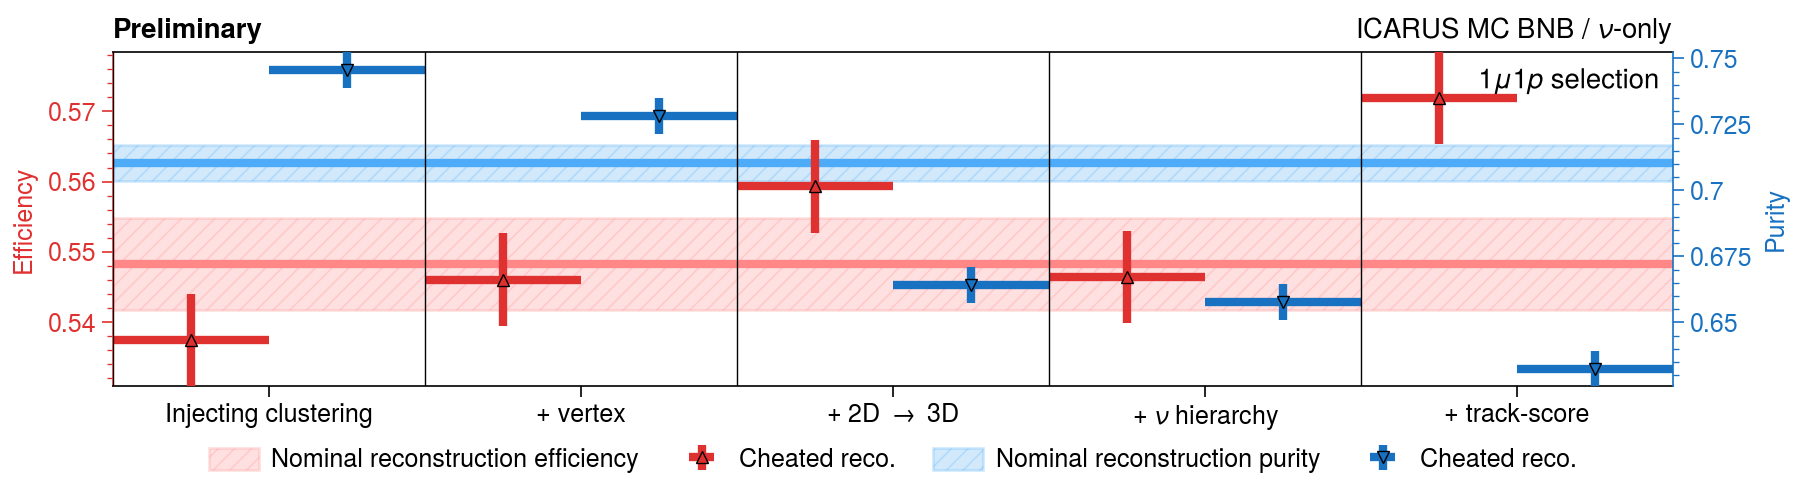

In [341]:
fig, ax = plot.subplots(
    width=9, height=2.5, ncols=1, nrows=1, ylabel=f'Efficiency',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    rtitle='ICARUS MC BNB / $\\nu$-only', 
    xticks=[0.5, 1.5, 2.5, 3.5, 4.5], 
    xticklabels=[
        'Injecting clustering',# 'Cheated $2\\mathrm{D}$', 
        '+ vertex',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex}$', 
        '+ 2D $\\to$ 3D',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D}$', 
        '+ $\\nu$ hierarchy',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D} + $\n$ + \\nu\\text{-hierarchy}$', 
        '+ track-score'# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D} + $\n$ + \\nu\\text{-hierarchy} + \\mathrm{MVA}$', 
    ],
    # xrotati,
    urtitle=r'$1\mu1p$ selection'
    # , yscale='log'
)

cheated_dict = {
    'xerr': 0.25, 
    'markersize': 4, 
    'mec': 'k', 
    'markeredgewidth': 0.5, 
    'capsize': 0, 
    'elinewidth': 3
}

trees = [
    'cheated_2D_loader',
    'cheated_2D_Vtx_loader',
    'cheated_2D_Vtx_3D_loader',
    'cheated_2D_Vtx_3D_Nu_loader',
    'cheated_2D_Vtx_3D_Nu_Mva_loader',
]


## NOMINAL RECO
efficiency, (low, high) = analysis_1u1p.efficiency('nominal_loader')
ax[0].axhspan(ymin=(efficiency-low)[0], ymax=(efficiency+high)[0], hatch='////', fill=True, color='red4', ec='red4', alpha=0.25, linewidth=1, label='Nominal reconstruction efficiency', zorder=-99)
ax[0].axhline(efficiency, lw=3, c='red4')

ax[0].format(ycolor='red8')
purity_ax = ax[0].alty(color='blue8', label='Purity')

purity, (low, high) = analysis_1u1p.purity('nominal_loader')
purity_ax.axhspan(ymin=(purity-low)[0], ymax=(purity+high)[0], hatch='////', fill=True, color='blue4', ec='blue4', alpha=0.25, linewidth=1, label='Nominal reconstruction purity', zorder=-99)
purity_ax.axhline(purity, lw=3, c='blue4')

## LADDER 
for i, tree in enumerate(trees):
    efficiency, uncertainty = analysis_1u1p.efficiency(tree)
    ax[0].errorbar(i+0.25, efficiency, yerr=uncertainty, **cheated_dict, color='red8', fmt='^', label=('Cheated reco.' if i==0 else None), zorder=99)

    purity, uncertainty = analysis_1u1p.purity(tree)
    purity_ax.errorbar(i+0.75, purity, yerr=uncertainty, **cheated_dict, color='blue8', fmt='v', label=('Cheated reco.' if i==0 else None), zorder=99)
    ax[0].axvline(i, color='k', lw=0.5, zorder=100)

# ax[1].format(urtitle='', ultitle=r'$1\mu1p$ selection')
[axi.legend(loc='b', ncols=4) for axi in ax]
[axi.set_title('Preliminary', color='k', loc='left', weight='bold') for axi in ax]


fig.savefig('2k_efficiency_purity_1µ1p.pdf', bbox_inches='tight')

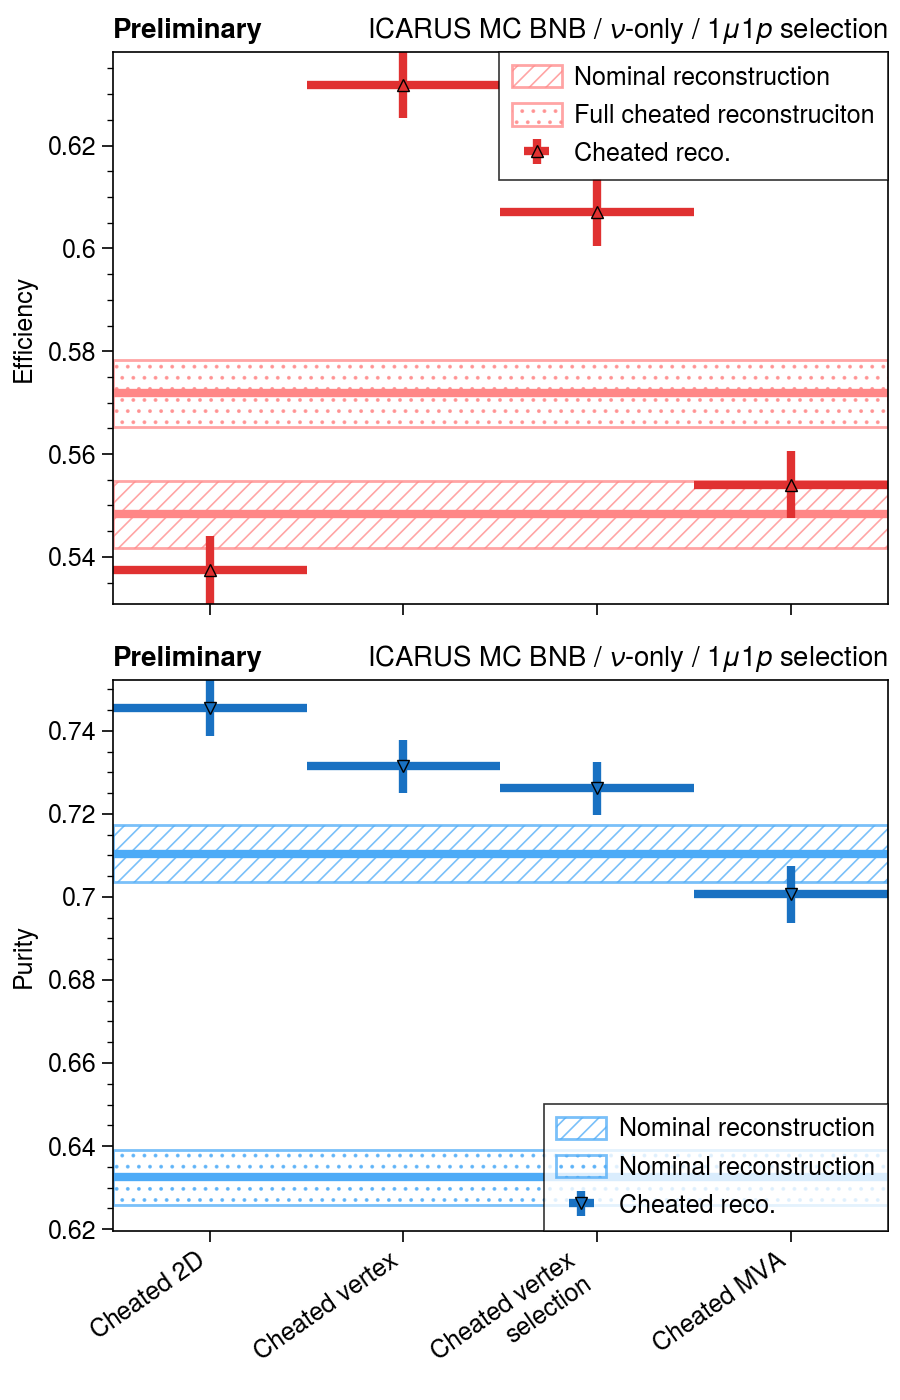

In [334]:
fig, ax = plot.subplots(
    width=4.5, height=7, ncols=1, nrows=2, ylabel='Efficiency',
    titlecolor='k', share=False, grid=False, sharex=True,
    rtitle=r'ICARUS MC BNB / $\nu$-only / $1\mu1p$ selection', 
    xticks=[0.5, 1.5, 2.5, 3.5, 4.5], 
    xticklabels=[
        'Cheated $2\\mathrm{D}$', 
        'Cheated vertex', 
        'Cheated vertex\nselection', 
        'Cheated MVA'
    ],
    xrotation=35,
    # , yscale='log'
)

cheated_dict = {
    'xerr': 0.5, 
    'markersize': 4, 
    'mec': 'k', 
    'markeredgewidth': 0.5, 
    'capsize': 0, 
    'elinewidth': 3
}

trees = [
    'cheated_2D_loader',
    'cheated_Vtx_loader',
    'cheated_VtxSelection_loader',
    'cheated_Mva_loader'
]


## NOMINAL RECO

for hatch, reco, label in zip(['////', '...'], ['nominal_loader', 'cheated_2D_Vtx_3D_Nu_Mva_loader'], ['Nominal reconstruction', 'Full cheated reconstruciton']):
    efficiency, (low, high) = analysis_1u1p.efficiency(reco)
    ax[0].axhspan(ymin=(efficiency-low)[0], ymax=(efficiency+high)[0], hatch=hatch, fill=False, ec='red4', alpha=0.75, linewidth=1, label=label)
    ax[0].axhline(efficiency, lw=3, c='red4')
    
    purity, (low, high) = analysis_1u1p.purity(reco)
    ax[1].axhspan(ymin=(purity-low)[0], ymax=(purity+high)[0], hatch=hatch, fill=False, ec='blue4', alpha=0.75, linewidth=1, label='Nominal reconstruction')
    ax[1].axhline(purity, lw=3, c='blue4')

## LADDER 
for i, tree in enumerate(trees):
    efficiency, uncertainty = analysis_1u1p.efficiency(tree)
    ax[0].errorbar(i+0.5, efficiency, yerr=uncertainty, **cheated_dict, color='red8', fmt='^', label=('Cheated reco.' if i==0 else None))

    purity, uncertainty = analysis_1u1p.purity(tree)
    ax[1].errorbar(i+0.5, purity, yerr=uncertainty, **cheated_dict, color='blue8', fmt='v', label=('Cheated reco.' if i==0 else None))

ax[1].format(ylabel='Purity')
ax[0].legend(ncols=1, loc='ur', frameon=True)
ax[1].legend(ncols=1, loc='lr', frameon=True)
[axi.set_title('Preliminary', color='k', loc='left', weight='bold') for axi in ax]

fig.savefig('2k_efficiency_purity_1µ1p_singles.pdf', bbox_inches='tight')

In [159]:

def plot_spectra(name, data=data_1u1p, color='teal', variable = 'true_E', energy_bins = hist.axis.Regular(18, 0.24, 2.4),
                 cheated_loader_mid='cheated_VtxSelection_loader', spectra_max=1700, eff_max=0.95):

    variable_dict = {
        'true_E': 'true energy',
        'reco_E': 'reconstructed energy',
        'reco_pT': 'reconstructed $p_T$'
    }
    
    cheated_dict = {
        'cheated_Vtx_loader': 'vertex',
        'cheated_VtxSelection_loader': 'vertex selection',
        'cheated_Mva_loader': 'track-score',
        'cheated_2D_loader': 'clustering'
    }

    analysis_1u1p = Analysis(data=data, binning=energy_bins)
    analysis_1u1p_integrated = Analysis(data=data, binning=hist.axis.Regular(1, 0.24, 2.4))

    fig, axs = plot.subplots(
        width=6.5, height=4, ncols=1, nrows=1, ylabel=f'Selected spills / {energy_bins.widths[0]:.2f} GeV',
        titlecolor='k', share=False, grid=False, 
        xlabel='Neutrino {} (GeV)'.format(variable_dict[variable]),
        rtitle=r'ICARUS MC BNB / $\nu$-only $1\mu1p$', 
        ltitle='Work in progress'
    )

    ax = axs[0]

    reco_true, _, true = analysis_1u1p.spectra('nominal_loader', variable)
    hep.histplot(true, ax=ax, histtype='fill', color='gray1', label=r'True $1\mu1p$')
    hep.histplot(reco_true, ax=ax, yerr=False, color='gray4', lw=3, label=r'Reco + true $1\mu1p$ (nominal reco.)')
        
    reco_true, _, _ = analysis_1u1p.spectra('{}'.format(cheated_loader_mid), variable)
    hep.histplot(reco_true, ax=ax, yerr=False, color='gray6', lw=1.5, ls='--', label=r'Reco + true $1\mu1p$ (cheated {})'.format(cheated_dict[cheated_loader_mid]))
    reco_true, _, _ = analysis_1u1p.spectra('cheated_2D_Vtx_3D_Nu_Mva_loader', variable)
    hep.histplot(reco_true, ax=ax, yerr=False, color='gray8', lw=1.5, ls=':', label=r'Reco + true $1\mu1p$ (cheated reco.)')
    
    ax.format(ymax=spectra_max)
    ax.legend(ncols=1, loc='ul')
        
    secax = ax.alty(color=f'{color}8', label=f'Efficiency / {energy_bins.widths[0]:.2f} GeV')
        
    efficiency, uncertainty = analysis_1u1p.efficiency('cheated_2D_Vtx_3D_Nu_Mva_loader', variable)
    integrated_efficiency, _ = analysis_1u1p_integrated.efficiency('cheated_2D_Vtx_3D_Nu_Mva_loader', variable)
    eb = secax.errorbar(energy_bins.centers, efficiency, yerr=uncertainty, xerr=energy_bins.widths[0]/2, 
                        color=f'{color}7', fmt='^', markersize=4, mec='k', markeredgewidth=0.5, capsize=0, elinewidth=1, label='Cheated reco. ({:.1f} %)'.format(integrated_efficiency[0]*100))
        
    efficiency, uncertainty = analysis_1u1p.efficiency('{}'.format(cheated_loader_mid), variable)
    integrated_efficiency, _ = analysis_1u1p_integrated.efficiency('{}'.format(cheated_loader_mid), variable)
    eb = secax.errorbar(energy_bins.centers, efficiency, yerr=uncertainty, xerr=energy_bins.widths[0]/2, color=f'{color}9', fmt='v', markersize=4, 
                        mec='k', markeredgewidth=0.5, capsize=0, elinewidth=3, label='Cheated {} ({:.1f} %)'.format(cheated_dict[cheated_loader_mid], integrated_efficiency[0]*100))
        
    efficiency, (low, high) = analysis_1u1p.efficiency('nominal_loader', variable)
    integrated_efficiency, _ = analysis_1u1p_integrated.efficiency('nominal_loader', variable)
    eb = secax.bar(x=energy_bins.centers, height=high+low, bottom=efficiency-low, alpha=0.5, width=1,
                        color=f'{color}5', label='Nominal reco. ({:.1f} %)'.format(integrated_efficiency[0]*100), edgefix=True)
    
    secax.format(ymax=eff_max)
    secax.legend(ncols=1, loc='ur')

    fig.savefig(name, bbox_inches='tight')

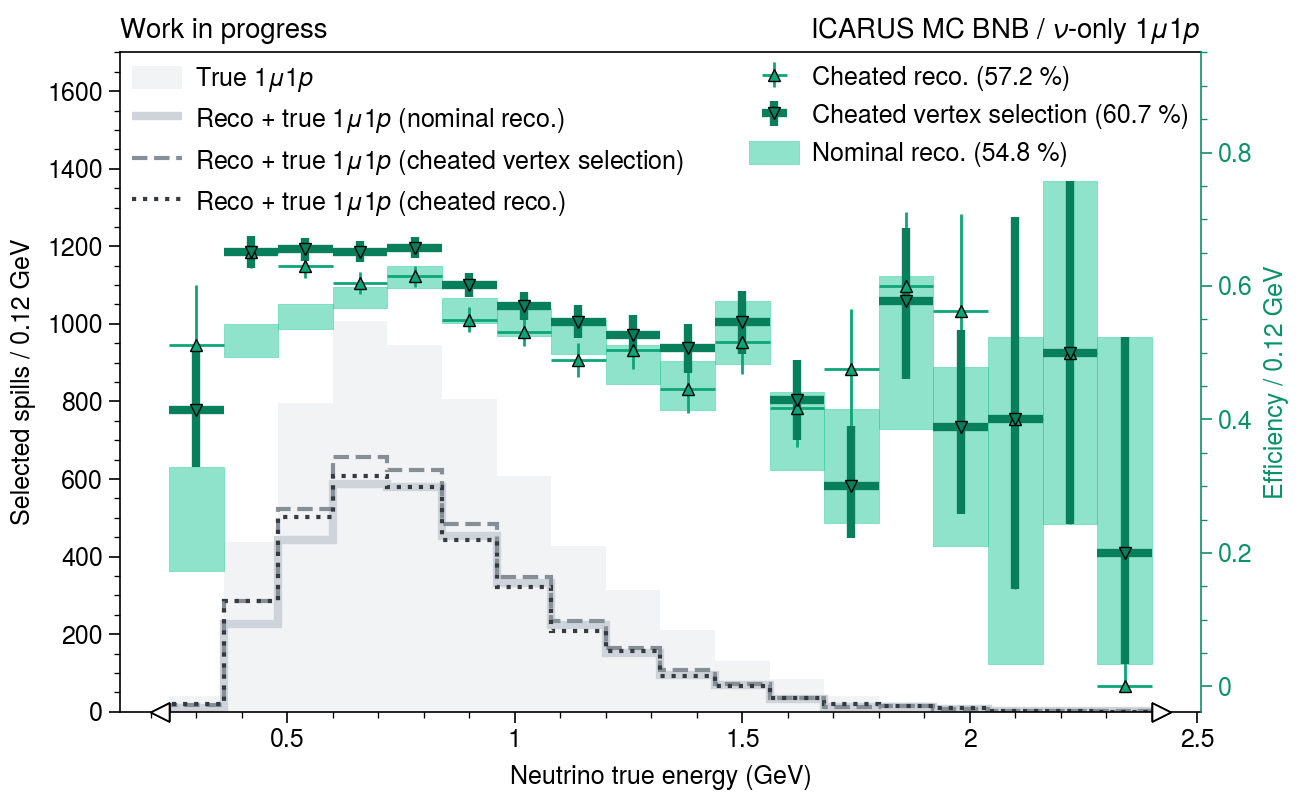

In [160]:
plot_spectra('2k_efficiency_vtxSelection.pdf', variable='true_E')

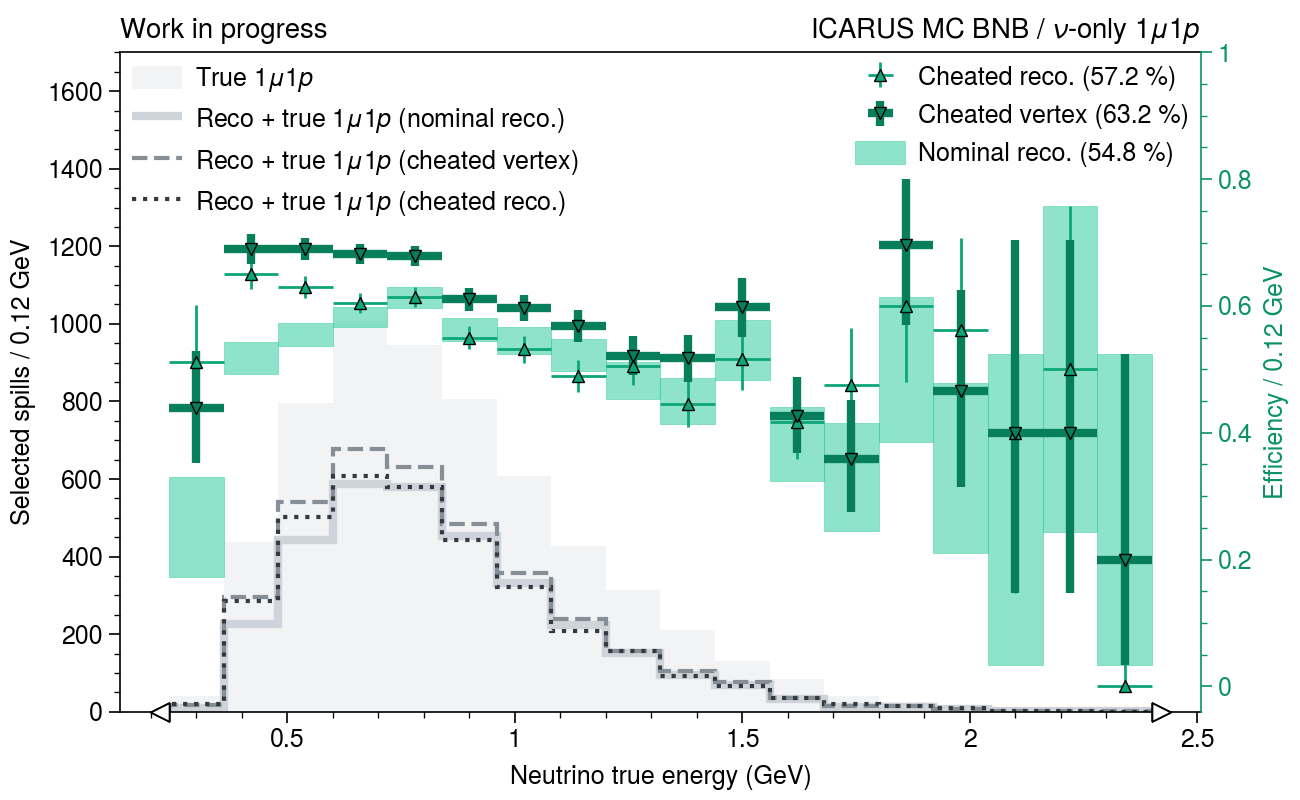

In [161]:
plot_spectra('2k_efficiency_vtx.pdf', cheated_loader_mid='cheated_Vtx_loader', eff_max=1.)

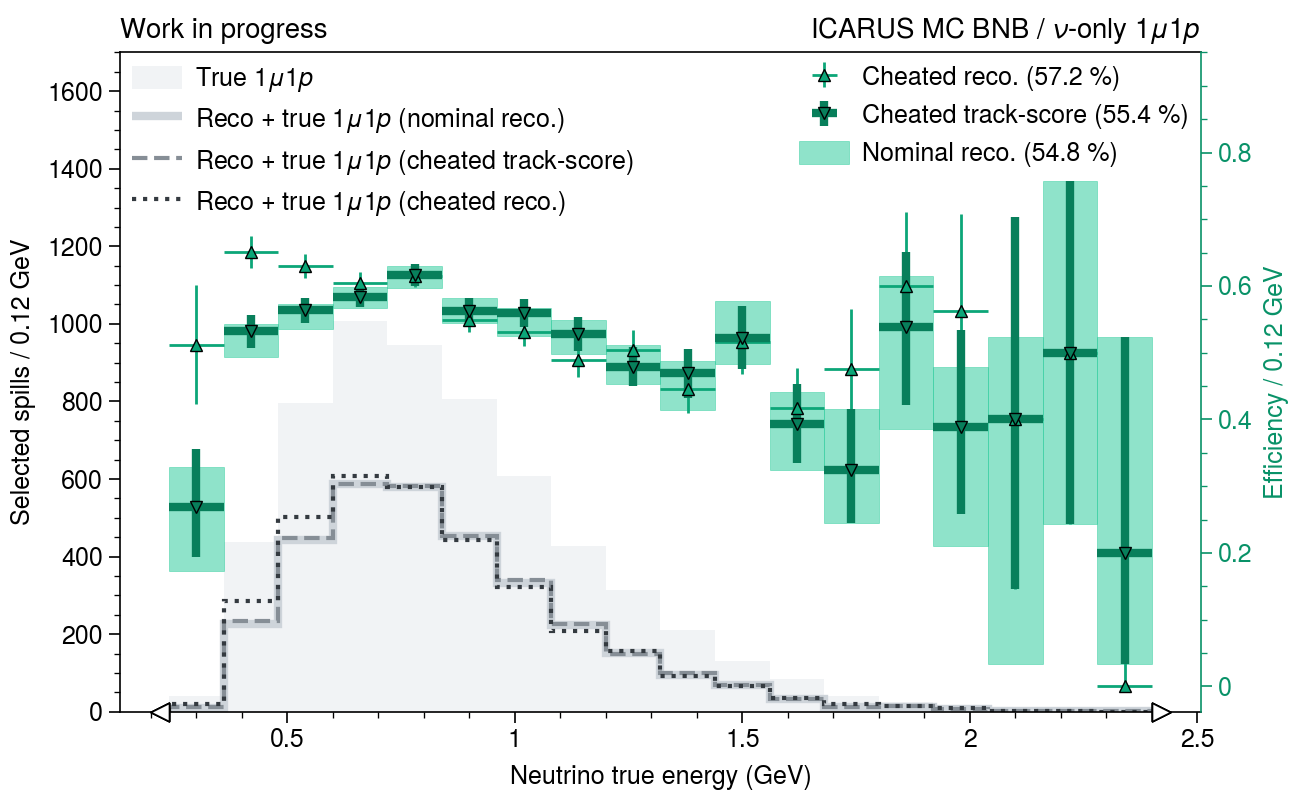

In [162]:
plot_spectra('2k_efficiency_mva.pdf', cheated_loader_mid='cheated_Mva_loader')

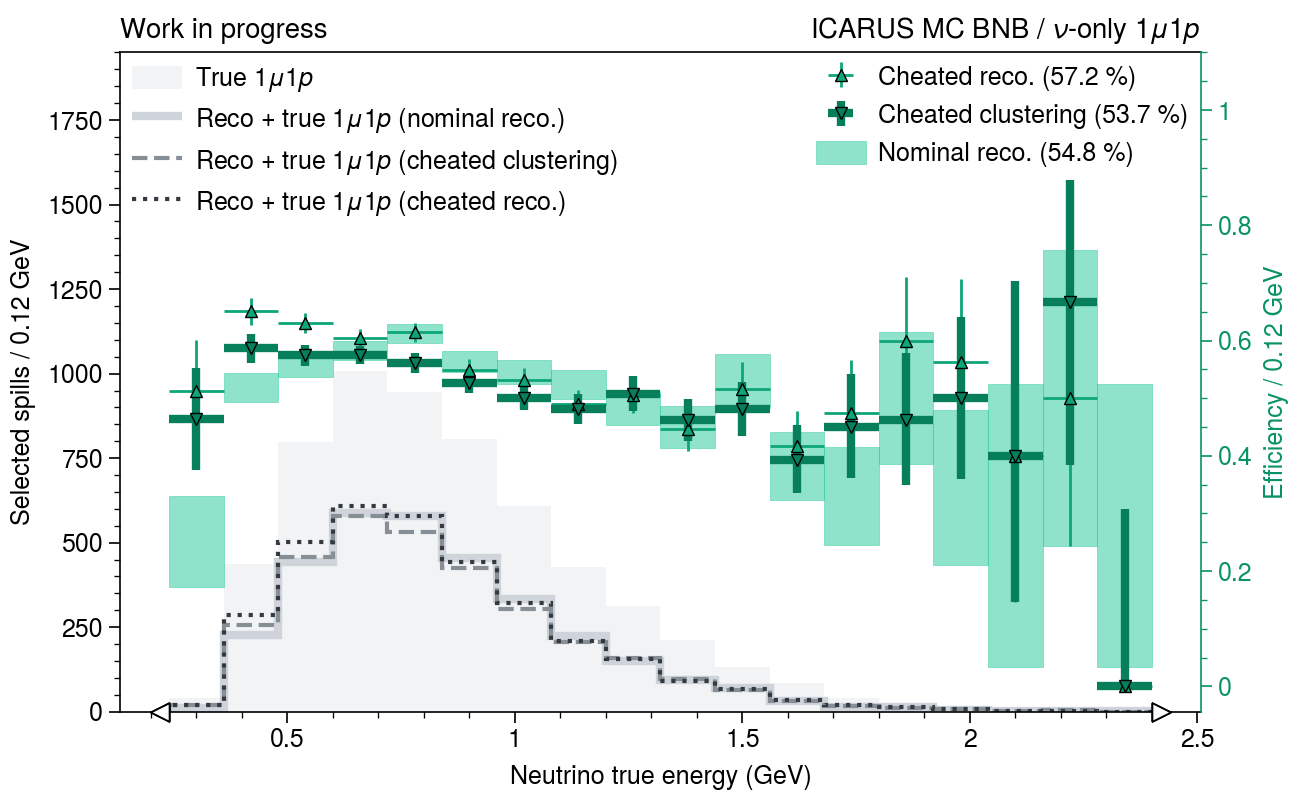

In [163]:
plot_spectra('2k_efficiency_2D.pdf', cheated_loader_mid='cheated_2D_loader', eff_max=1.1, spectra_max=1950)

In [295]:
def plot_spectra_purity(name, data=data_1u1p, color='teal', variable = 'true_E', energy_bins = hist.axis.Regular(18, 0.24, 2.4),
                 cheated_loader_mid='cheated_VtxSelection_loader', spectra_max=1700, eff_max=0.95):

    variable_dict = {
        'true_E': 'true energy',
        'reco_E': 'reconstructed energy',
        'reco_pT': 'reconstructed $p_T$'
    }
    
    cheated_dict = {
        'cheated_Vtx_loader': 'vertex',
        'cheated_VtxSelection_loader': 'vertex selection',
        'cheated_Mva_loader': 'track-score',
        'cheated_2D_loader': 'clustering'
    }

    analysis_1u1p = Analysis(data=data, binning=energy_bins)
    analysis_1u1p_integrated = Analysis(data=data, binning=hist.axis.Regular(1, 0.24, 2.4))

    fig, axs = plot.subplots(
        width=6.5, height=4, ncols=1, nrows=1, ylabel=f'Selected spills / {energy_bins.widths[0]:.2f} GeV',
        titlecolor='k', share=False, grid=False, 
        xlabel='Neutrino {} (GeV)'.format(variable_dict[variable]),
        rtitle=r'ICARUS MC BNB / $\nu$-only $1\mu1p$', 
        ltitle='Work in progress'
    )

    ax = axs[0]

    reco_true, _, true = analysis_1u1p.spectra('nominal_loader', variable)
    hep.histplot(true, ax=ax, histtype='fill', color='gray1', label=r'True $1\mu1p$')
    hep.histplot(reco_true, ax=ax, yerr=False, color='gray4', lw=3, label=r'Reco + true $1\mu1p$ (nominal reco.)')
        
    reco_true, _, _ = analysis_1u1p.spectra('{}'.format(cheated_loader_mid), variable)
    hep.histplot(reco_true, ax=ax, yerr=False, color='gray6', lw=1.5, ls='--', label=r'Reco + true $1\mu1p$ (cheated {})'.format(cheated_dict[cheated_loader_mid]))
    reco_true, _, _ = analysis_1u1p.spectra('cheated_2D_Vtx_3D_Nu_Mva_loader', variable)
    hep.histplot(reco_true, ax=ax, yerr=False, color='gray8', lw=1.5, ls=':', label=r'Reco + true $1\mu1p$ (cheated reco.)')
    
    ax.format(ymax=spectra_max)
    ax.legend(ncols=1, loc='ul')
        
    secax = ax.alty(color=f'{color}8', label=f'Purity / {energy_bins.widths[0]:.2f} GeV')
        
    purity, uncertainty = analysis_1u1p.purity('cheated_2D_Vtx_3D_Nu_Mva_loader', variable)
    integrated_purity, _ = analysis_1u1p_integrated.purity('cheated_2D_Vtx_3D_Nu_Mva_loader', variable)
    eb = secax.errorbar(energy_bins.centers, purity, yerr=uncertainty, xerr=energy_bins.widths[0]/2, 
                        color=f'{color}7', fmt='^', markersize=4, mec='k', markeredgewidth=0.5, capsize=0, elinewidth=1, label='Cheated reco. ({:.1f} %)'.format(integrated_purity[0]*100))
        
    purity, uncertainty = analysis_1u1p.purity('{}'.format(cheated_loader_mid), variable)
    integrated_purity, _ = analysis_1u1p_integrated.purity('{}'.format(cheated_loader_mid), variable)
    eb = secax.errorbar(energy_bins.centers, purity, yerr=uncertainty, xerr=energy_bins.widths[0]/2, color=f'{color}9', fmt='v', markersize=4, 
                        mec='k', markeredgewidth=0.5, capsize=0, elinewidth=3, label='Cheated {} ({:.1f} %)'.format(cheated_dict[cheated_loader_mid], integrated_purity[0]*100))
        
    purity, (low, high) = analysis_1u1p.purity('nominal_loader', variable)
    integrated_purity, _ = analysis_1u1p_integrated.purity('nominal_loader', variable)
    eb = secax.bar(x=energy_bins.centers, height=high+low, bottom=purity-low, alpha=0.5, width=1,
                        color=f'{color}5', label='Nominal reco. ({:.1f} %)'.format(integrated_purity[0]*100), edgefix=True)
    
    secax.format(ymax=eff_max)
    secax.legend(ncols=1, loc='ur')

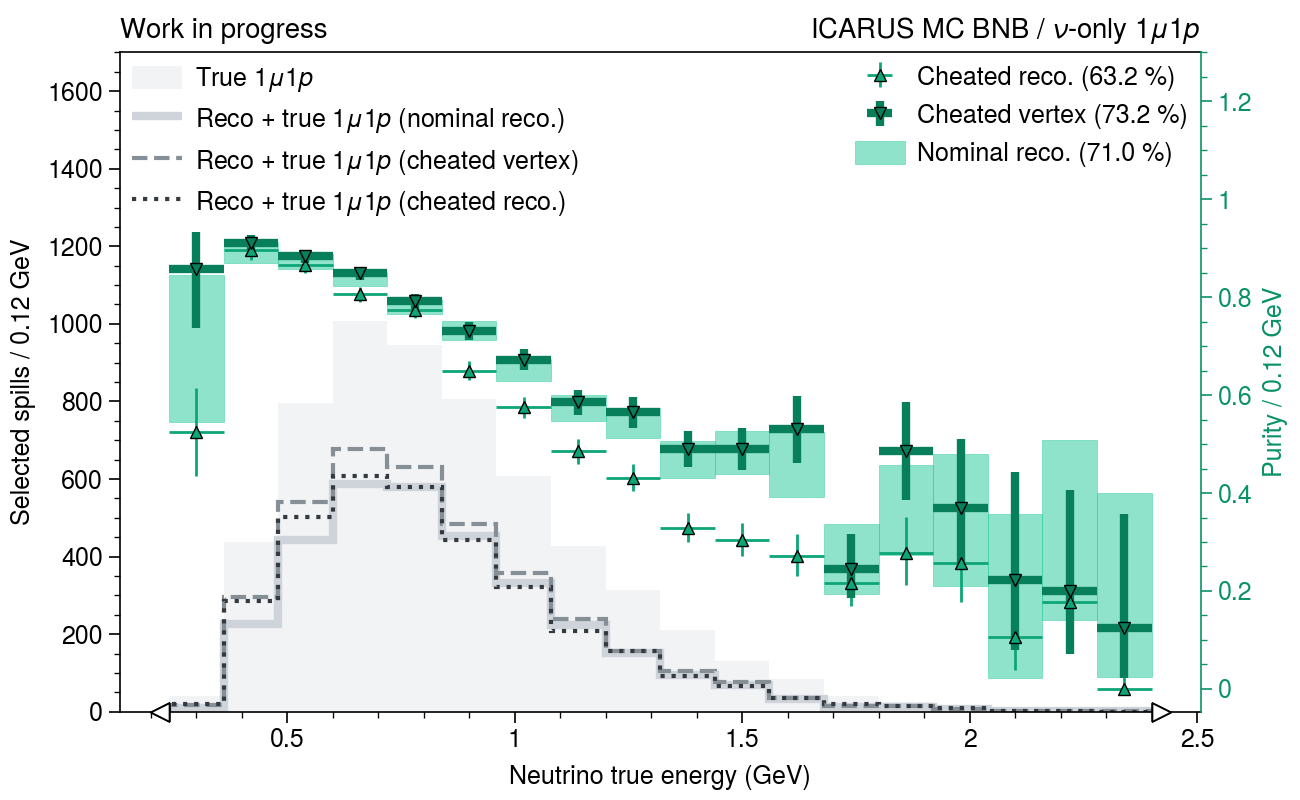

In [298]:
plot_spectra_purity('', cheated_loader_mid='cheated_Vtx_loader', eff_max=1.3)

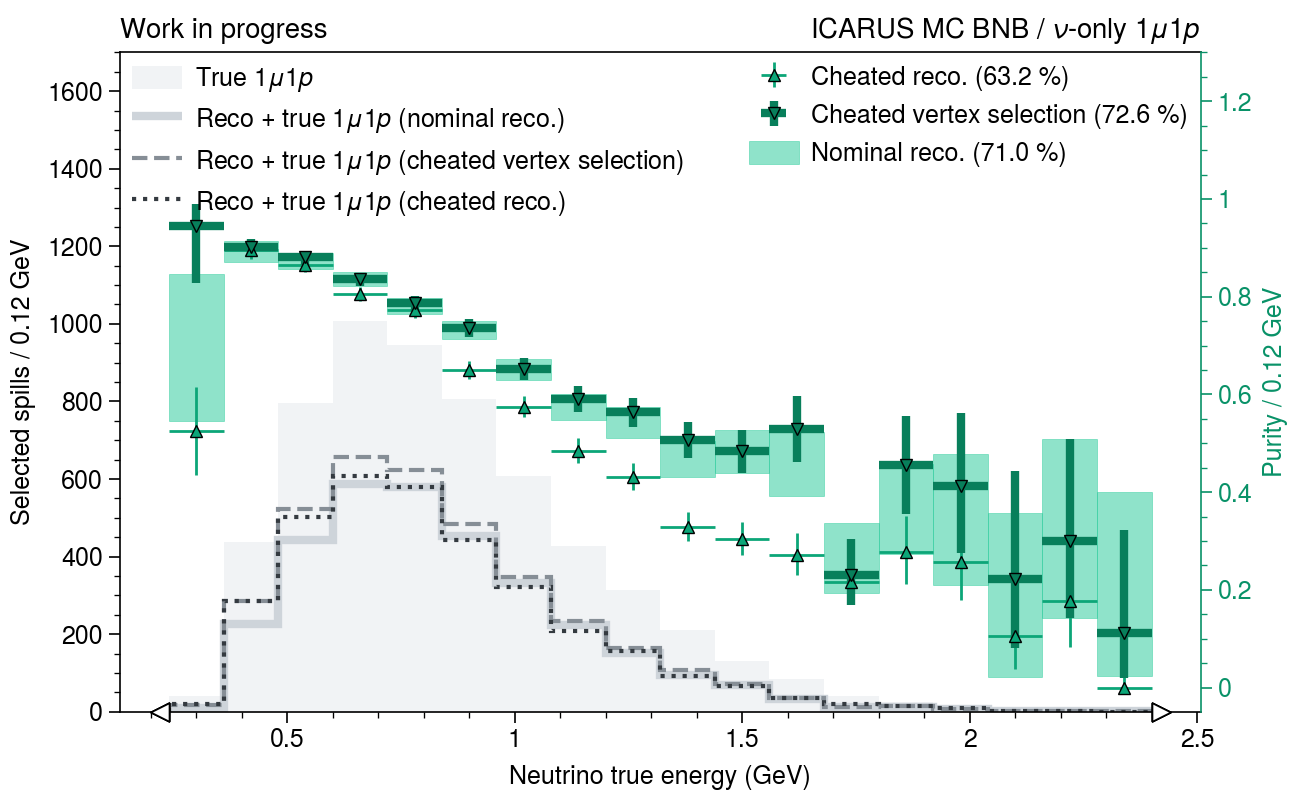

In [299]:

plot_spectra_purity('', cheated_loader_mid='cheated_VtxSelection_loader', eff_max=1.3)

### Impact of single cuts on the selection



In [300]:


def plot_selections(data=uproot.open('2k_efficiency_plot_1u1p_cuts.root:efficiency_studies'), stage1='cheated_2D_loader'):

    energy_bins=hist.axis.Regular(18, 0.24, 2.4)
    analysis_1u1p = Analysis(data=data, binning=energy_bins)
    analysis_1u1p_integrated = Analysis(data=data, binning=hist.axis.Regular(1, 0.24, 2.4))

    stage1_dict = {
        'cheated_Vtx_loader': 'Cheated vertex',
        'cheated_VtxSelection_loader': 'Cheated vertex selection',
        'cheated_Mva_loader': 'Cheated track-score',
        'cheated_2D_loader': 'Cheated clustering',
        'nominal_loader': 'Nominal reconstruction'
    }
    
    fig, axs = plot.subplots(
        width=6.5, height=4.5, ncols=1, nrows=1, ylabel=f'Selected spills / {energy_bins.widths[0]:.2f} GeV',
        titlecolor='k', share=False, grid=False, 
        xlabel='Neutrino {} (GeV)'.format(variable_dict[variable]),
        rtitle=f'ICARUS MC BNB / $\\nu$-only $1\\mu1p$ / {stage1_dict[stage1]}', 
        ltitle='Work in progress'
    )

    ax = axs[0]

    reco_true, _, true = analysis_1u1p.spectra(stage1, 's7')
    hep.histplot(true, ax=ax, histtype='fill', color='gray1')

    
    
    selections = {
        's1': 'CRT-PMT match',
        's2': 'Flash-match',
        's3': 'Vertex in FV',
        's4': 'Containment',
        's5': r'$\mu$ ID',
        's6': 'Proton ID',
        's7': r'$0\pi$ and $0\gamma$'
    }

    cidx = 6

    selection_colors = {
        's1': f'yellow{cidx}',
        's3': f'lime{cidx}',
        's2': f'blue{cidx}',
        's4': f'orange{cidx}',
        's5': f'red{cidx}',
        's6': f'pink{cidx}',
        's7': f'indigo{cidx}',
    }

        

    secax = ax.alty(label=f'Efficiency / {energy_bins.widths[0]:.2f} GeV')
    
    for key in selections:
        efficiency, uncertainty = analysis_1u1p.efficiency(stage1, key)
        integrated_efficiency, _ = analysis_1u1p_integrated.efficiency(stage1, key)
        secax.errorbar(energy_bins.centers, efficiency, yerr=uncertainty, xerr=energy_bins.widths[0]/2, color=selection_colors[key],
                       fmt='o', markersize=4, mec='k', markeredgewidth=0.5, capsize=0, elinewidth=3, alpha=0.5,
                       label='{} ({:.1f} %)'.format(selections[key], integrated_efficiency[0]*100))


    secax.format(ymax=1.25)
    ax.format(ymax=1350)
    secax.legend(order='C', mode='extend')

    a, _ = stage1.split('_loader')
    fig.savefig(f'2k_efficiency_cuts_{a}.pdf', bbox_inches='tight')


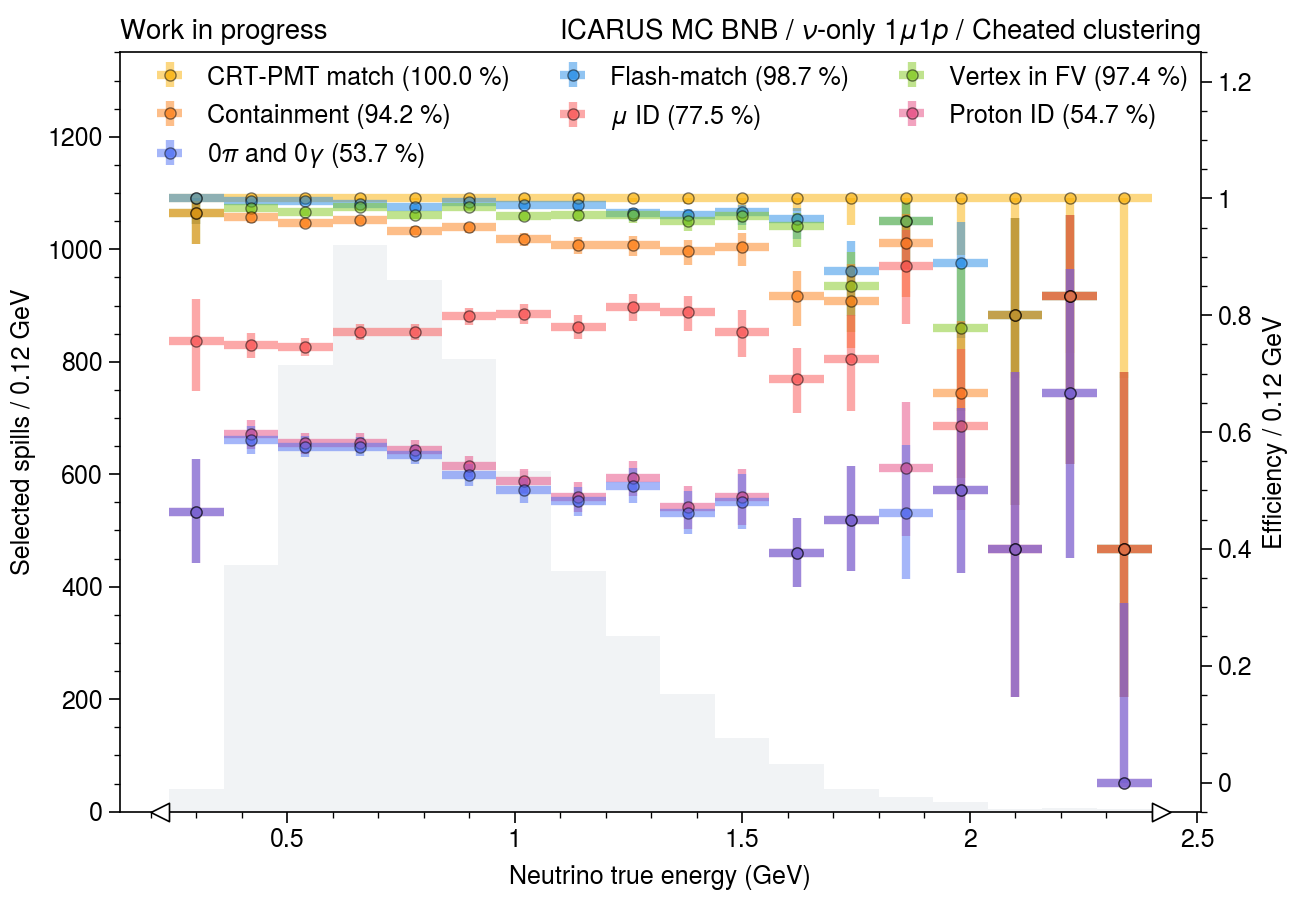

In [301]:
plot_selections(stage1='cheated_2D_loader')

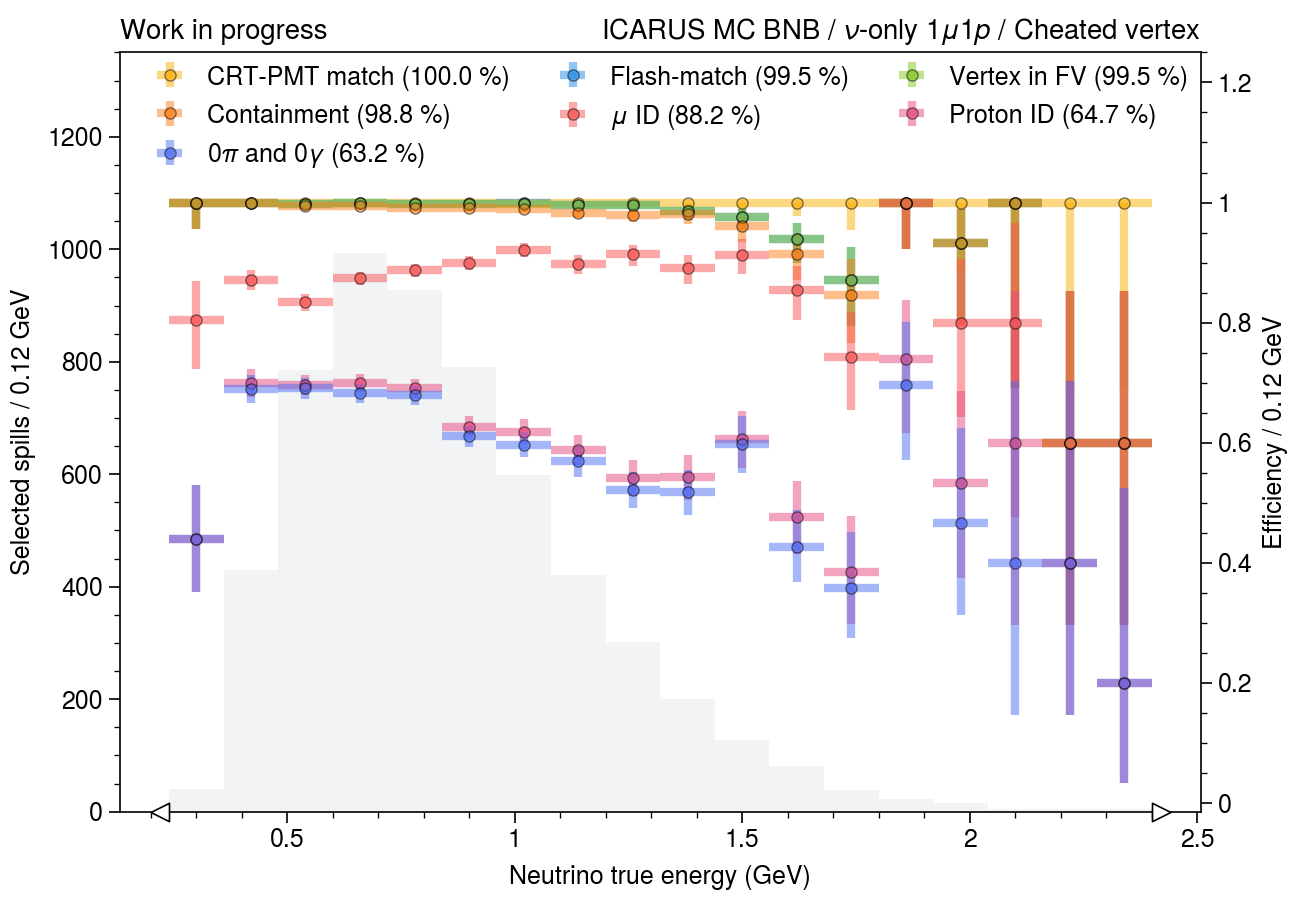

In [302]:
plot_selections(stage1='cheated_Vtx_loader')

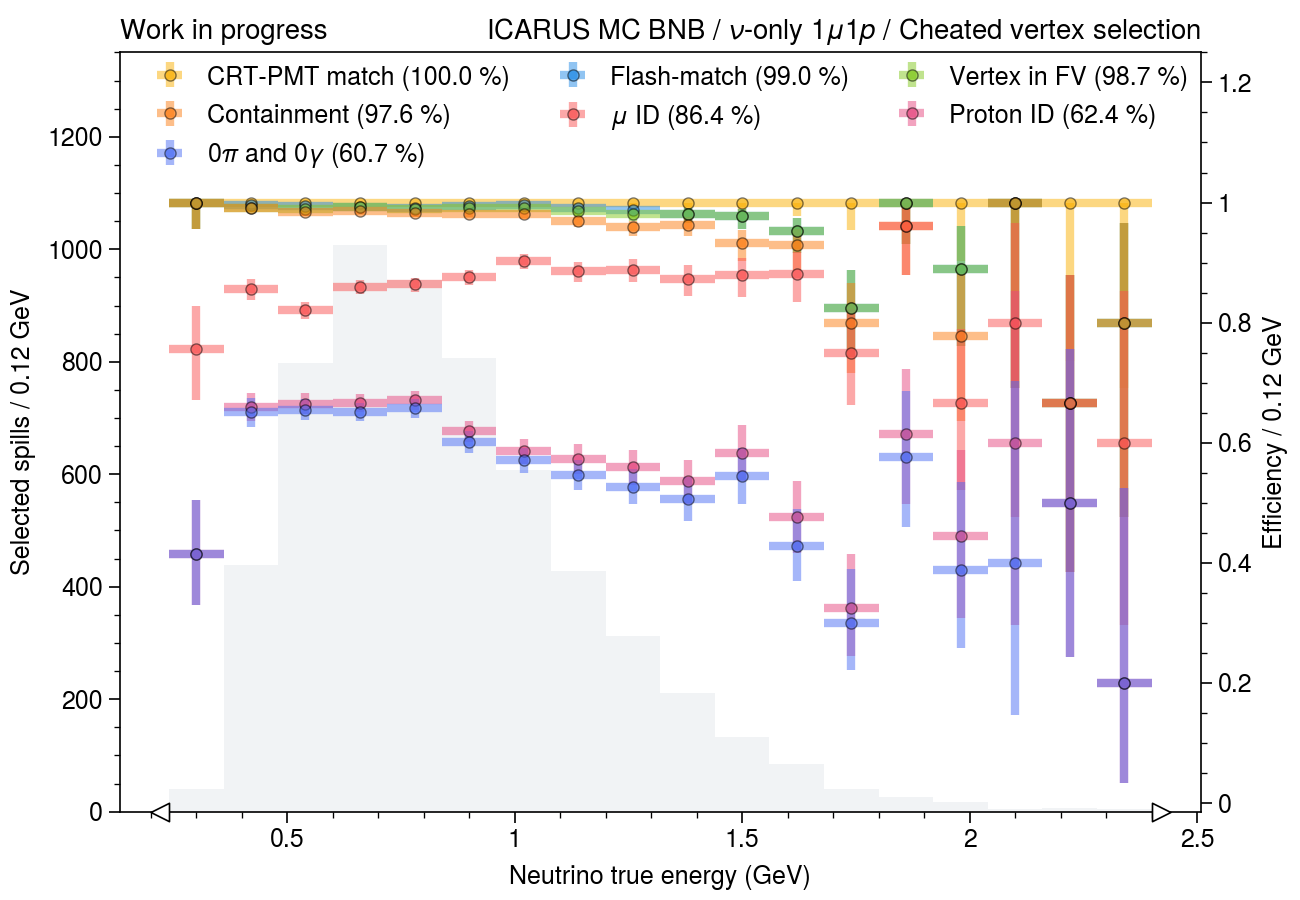

In [303]:
plot_selections(stage1='cheated_VtxSelection_loader')

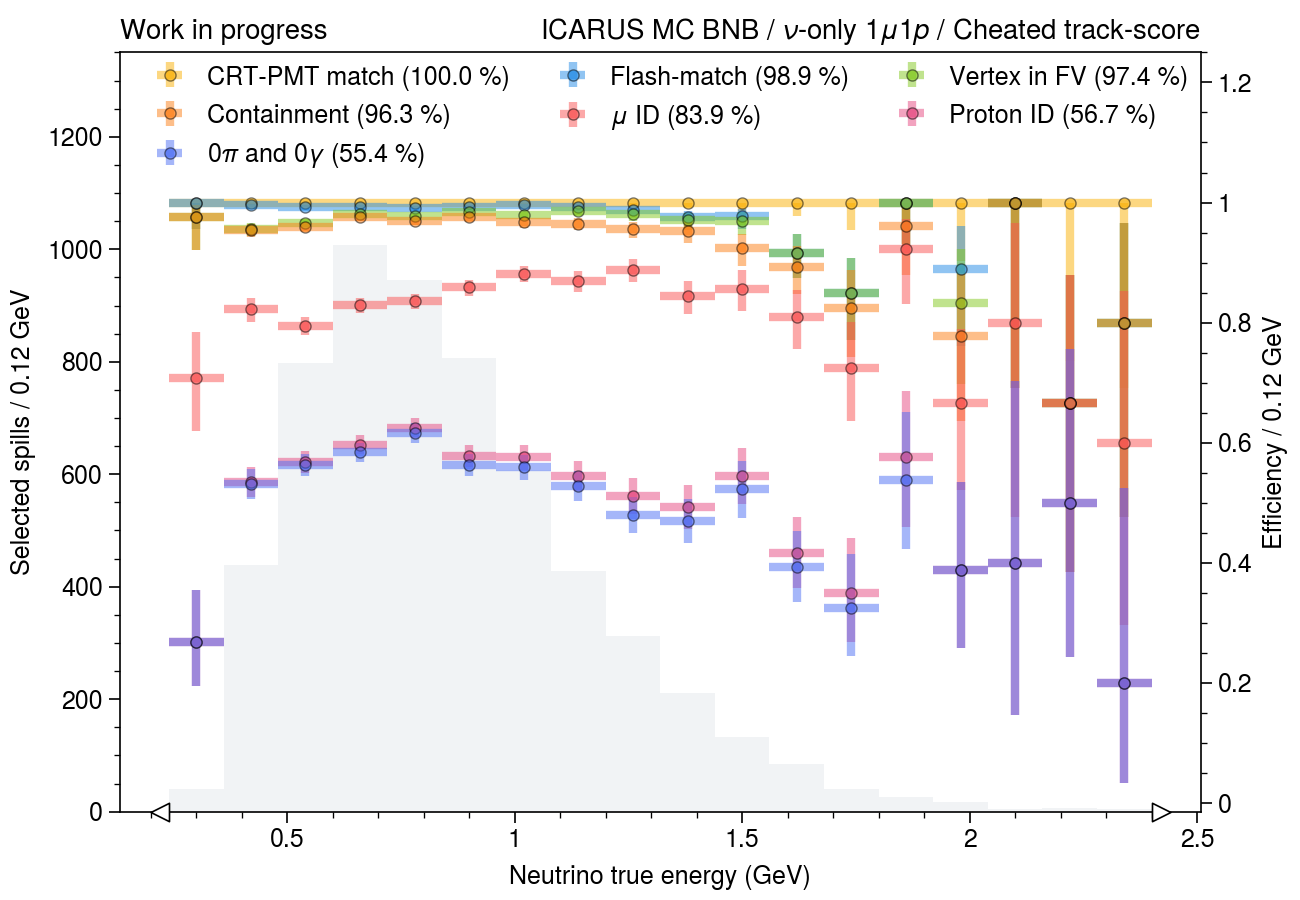

In [304]:
plot_selections(stage1='cheated_Mva_loader')

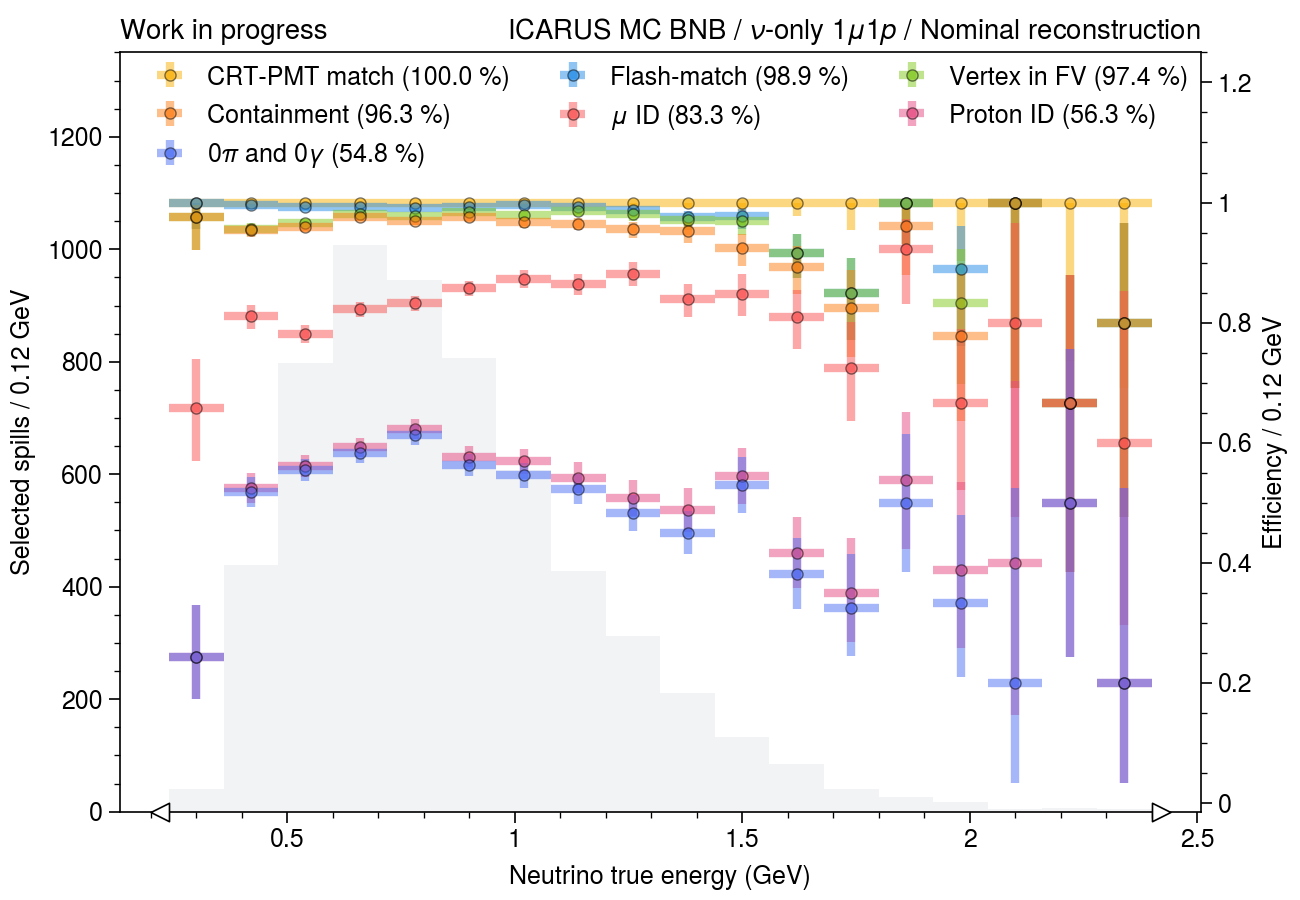

In [305]:
plot_selections(stage1='nominal_loader')

## 1µNp selection

In [142]:
data_1uNp = uproot.open('2k_efficiency_plot_1uNp.root:efficiency_studies')
analysis_1uNp = Analysis(data_1uNp, binning=hist.axis.Regular(1, 0.24, 2.4))


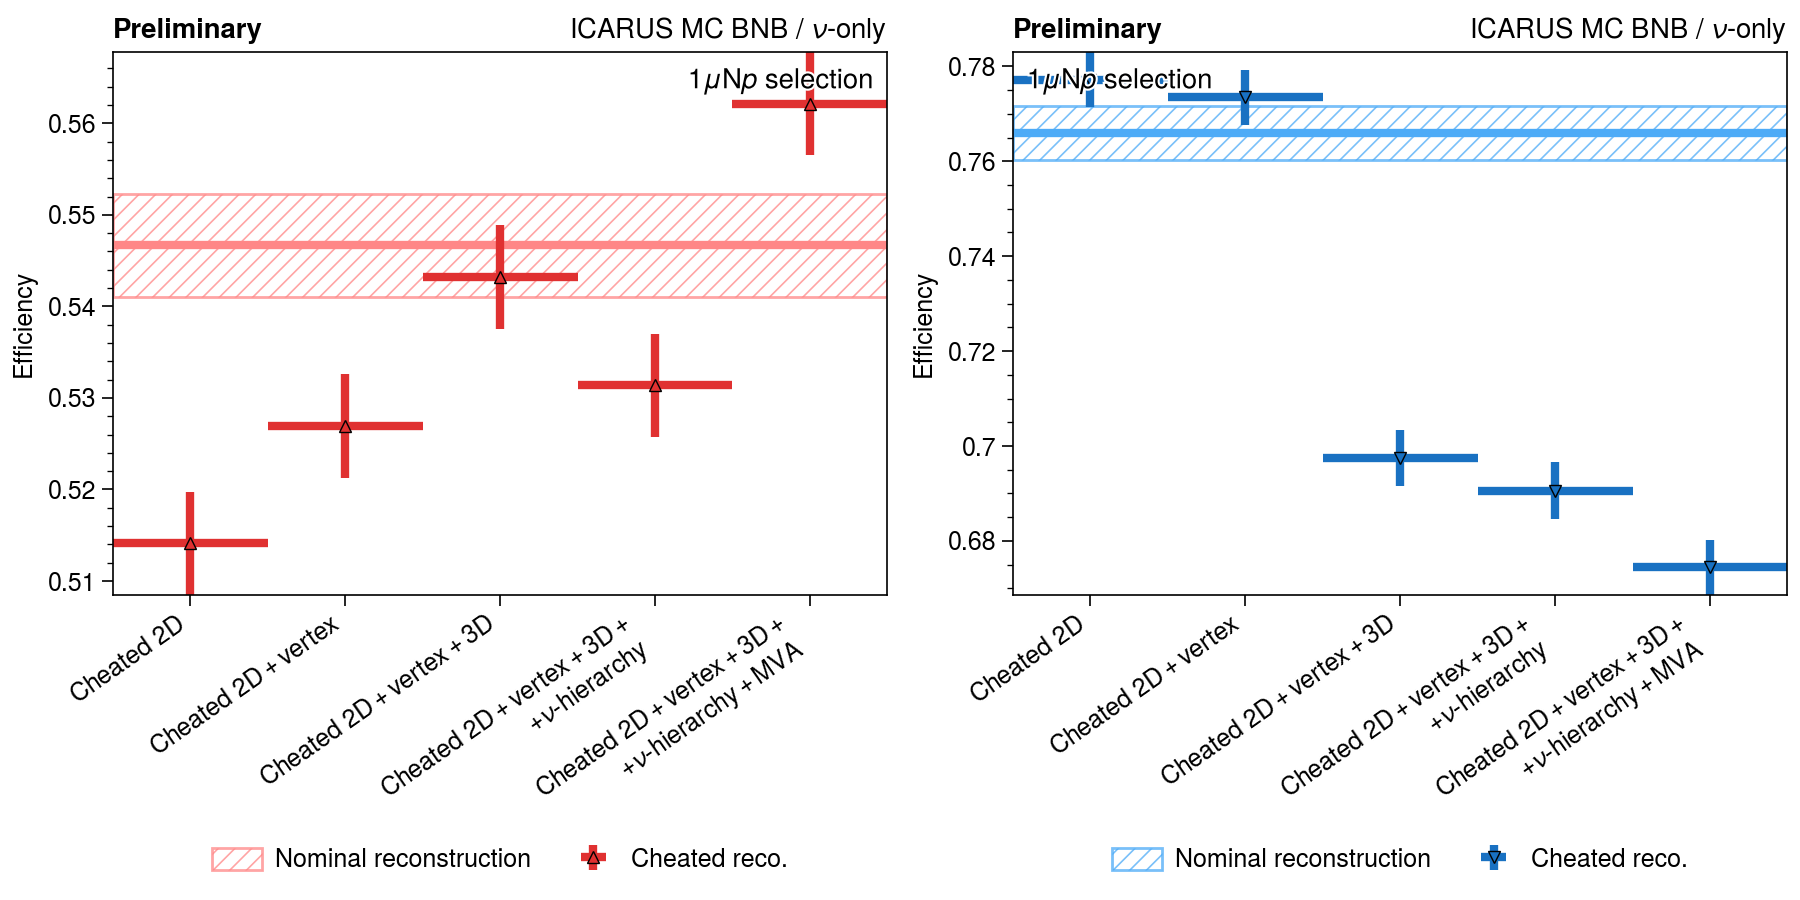

In [144]:
fig, ax = plot.subplots(
    width=9, height=4.5, ncols=2, nrows=1, ylabel=f'Efficiency',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    rtitle='ICARUS MC BNB / $\\nu$-only', 
    xticks=[0.5, 1.5, 2.5, 3.5, 4.5], 
    xticklabels=[
        'Cheated $2\\mathrm{D}$', 
        'Cheated $2\\mathrm{D} + \\mathrm{vertex}$', 
        'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D}$', 
        'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D} + $\n$ + \\nu\\text{-hierarchy}$', 
        'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D} + $\n$ + \\nu\\text{-hierarchy} + \\mathrm{MVA}$', 
    ],
    xrotation=35,
    urtitle=r'$1\mu\mathrm{N}p$ selection'
    # , yscale='log'
)

cheated_dict = {
    'xerr': 0.5, 
    'markersize': 4, 
    'mec': 'k', 
    'markeredgewidth': 0.5, 
    'capsize': 0, 
    'elinewidth': 3
}

trees = [
    'cheated_2D_loader',
    'cheated_2D_Vtx_loader',
    'cheated_2D_Vtx_3D_loader',
    'cheated_2D_Vtx_3D_Nu_loader',
    'cheated_2D_Vtx_3D_Nu_Mva_loader',
]


## NOMINAL RECO
efficiency, (low, high) = analysis_1uNp.efficiency('nominal_loader')
ax[0].axhspan(ymin=(efficiency-low)[0], ymax=(efficiency+high)[0], hatch='////', fill=False, ec='red4', alpha=0.75, linewidth=1, label='Nominal reconstruction')
ax[0].axhline(efficiency, lw=3, c='red4')

purity, (low, high) = analysis_1uNp.purity('nominal_loader')
ax[1].axhspan(ymin=(purity-low)[0], ymax=(purity+high)[0], hatch='////', fill=False, ec='blue4', alpha=0.75, linewidth=1, label='Nominal reconstruction')
ax[1].axhline(purity, lw=3, c='blue4')

## LADDER 
for i, tree in enumerate(trees):
    efficiency, uncertainty = analysis_1uNp.efficiency(tree)
    ax[0].errorbar(i+0.5, efficiency, yerr=uncertainty, **cheated_dict, color='red8', fmt='^', label=('Cheated reco.' if i==0 else None))

    purity, uncertainty = analysis_1uNp.purity(tree)
    ax[1].errorbar(i+0.5, purity, yerr=uncertainty, **cheated_dict, color='blue8', fmt='v', label=('Cheated reco.' if i==0 else None))

ax[1].format(urtitle='', ultitle=r'$1\mu\mathrm{N}p$ selection')
[axi.legend(loc='b') for axi in ax]
[axi.set_title('Preliminary', color='k', loc='left', weight='bold') for axi in ax]

fig.savefig('2k_efficiency_purity_1µNp.pdf', bbox_inches='tight')

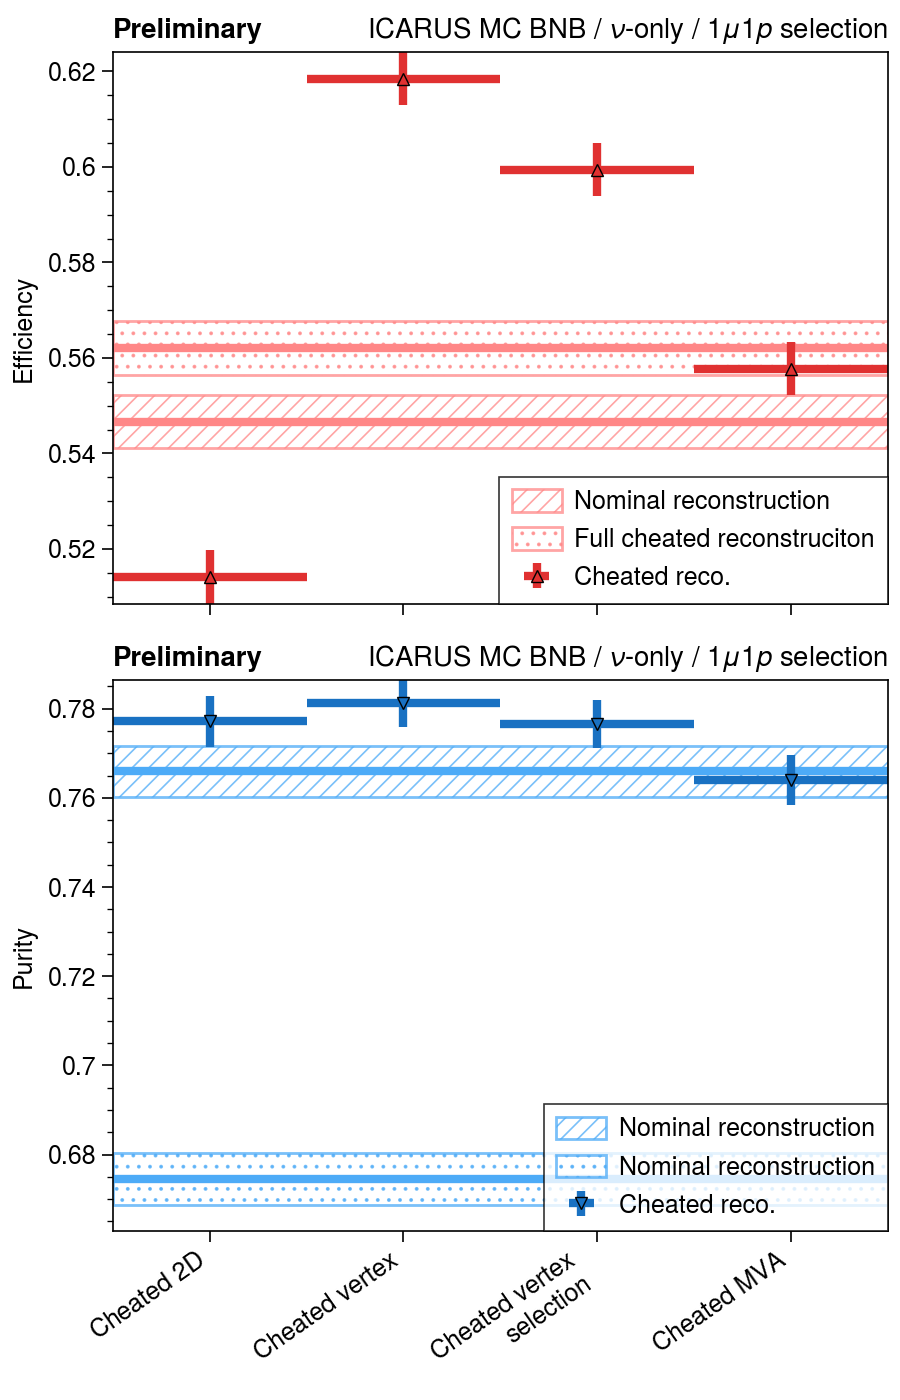

In [148]:
fig, ax = plot.subplots(
    width=4.5, height=7, ncols=1, nrows=2, ylabel='Efficiency',
    titlecolor='k', share=False, grid=False, sharex=True,
    rtitle=r'ICARUS MC BNB / $\nu$-only / $1\mu1p$ selection', 
    xticks=[0.5, 1.5, 2.5, 3.5, 4.5], 
    xticklabels=[
        'Cheated $2\\mathrm{D}$', 
        'Cheated vertex', 
        'Cheated vertex\nselection', 
        'Cheated MVA'
    ],
    xrotation=35,
    # , yscale='log'
)

cheated_dict = {
    'xerr': 0.5, 
    'markersize': 4, 
    'mec': 'k', 
    'markeredgewidth': 0.5, 
    'capsize': 0, 
    'elinewidth': 3
}

trees = [
    'cheated_2D_loader',
    'cheated_Vtx_loader',
    'cheated_VtxSelection_loader',
    'cheated_Mva_loader'
]


## NOMINAL RECO

for hatch, reco, label in zip(['////', '...'], ['nominal_loader', 'cheated_2D_Vtx_3D_Nu_Mva_loader'], ['Nominal reconstruction', 'Full cheated reconstruciton']):
    efficiency, (low, high) = analysis_1uNp.efficiency(reco)
    ax[0].axhspan(ymin=(efficiency-low)[0], ymax=(efficiency+high)[0], hatch=hatch, fill=False, ec='red4', alpha=0.75, linewidth=1, label=label)
    ax[0].axhline(efficiency, lw=3, c='red4')
    
    purity, (low, high) = analysis_1uNp.purity(reco)
    ax[1].axhspan(ymin=(purity-low)[0], ymax=(purity+high)[0], hatch=hatch, fill=False, ec='blue4', alpha=0.75, linewidth=1, label='Nominal reconstruction')
    ax[1].axhline(purity, lw=3, c='blue4')

## LADDER 
for i, tree in enumerate(trees):
    efficiency, uncertainty = analysis_1uNp.efficiency(tree)
    ax[0].errorbar(i+0.5, efficiency, yerr=uncertainty, **cheated_dict, color='red8', fmt='^', label=('Cheated reco.' if i==0 else None))

    purity, uncertainty = analysis_1uNp.purity(tree)
    ax[1].errorbar(i+0.5, purity, yerr=uncertainty, **cheated_dict, color='blue8', fmt='v', label=('Cheated reco.' if i==0 else None))

ax[1].format(ylabel='Purity')
ax[0].legend(ncols=1, loc='lr', frameon=True)
ax[1].legend(ncols=1, loc='lr', frameon=True)
[axi.set_title('Preliminary', color='k', loc='left', weight='bold') for axi in ax]

fig.savefig('2k_efficiency_purity_1µ1p_singles.pdf', bbox_inches='tight')

In [152]:

def plot_spectra(name, data=data_1uNp, color='teal', variable = 'true_E', energy_bins = hist.axis.Regular(18, 0.24, 2.4),
                 cheated_loader_mid='cheated_VtxSelection_loader', spectra_max=1700, eff_max=0.95):

    variable_dict = {
        'true_E': 'true energy',
        'reco_E': 'reconstructed energy',
        'reco_pT': 'reconstructed $p_T$'
    }
    
    cheated_dict = {
        'cheated_Vtx_loader': 'vertex',
        'cheated_VtxSelection_loader': 'vertex selection',
        'cheated_Mva_loader': 'track-score',
        'cheated_2D_loader': 'clustering'
    }

    analysis_1uNp = Analysis(data=data, binning=energy_bins)
    analysis_1uNp_integrated = Analysis(data=data, binning=hist.axis.Regular(1, 0.24, 2.4))

    fig, axs = plot.subplots(
        width=6.5, height=4, ncols=1, nrows=1, ylabel=f'Selected spills / {energy_bins.widths[0]:.2f} GeV',
        titlecolor='k', share=False, grid=False, 
        xlabel='Neutrino {} (GeV)'.format(variable_dict[variable]),
        rtitle=r'ICARUS MC BNB / $\nu$-only $1\mu\mathrm{N}p$', 
        ltitle='Work in progress'
    )

    ax = axs[0]

    reco_true, _, true = analysis_1uNp.spectra('nominal_loader', variable)
    hep.histplot(true, ax=ax, histtype='fill', color='gray1', label=r'True $1\mu1p$')
    hep.histplot(reco_true, ax=ax, yerr=False, color='gray4', lw=3, label=r'Reco + true $1\mu\mathrm{N}p$ (nominal reco.)')
        
    reco_true, _, _ = analysis_1uNp.spectra('{}'.format(cheated_loader_mid), variable)
    hep.histplot(reco_true, ax=ax, yerr=False, color='gray6', lw=1.5, ls='--', label=r'Reco + true $1\mu\mathrm{{N}}p$ (cheated {})'.format(cheated_dict[cheated_loader_mid]))
    reco_true, _, _ = analysis_1uNp.spectra('cheated_2D_Vtx_3D_Nu_Mva_loader', variable)
    hep.histplot(reco_true, ax=ax, yerr=False, color='gray8', lw=1.5, ls=':', label=r'Reco + true $1\mu\mathrm{N}p$ (cheated reco.)')
    
    ax.format(ymax=spectra_max)
    ax.legend(ncols=1, loc='ul')
        
    secax = ax.alty(color=f'{color}8', label=f'Efficiency / {energy_bins.widths[0]:.2f} GeV')
        
    efficiency, uncertainty = analysis_1uNp.efficiency('cheated_2D_Vtx_3D_Nu_Mva_loader', variable)
    integrated_efficiency, _ = analysis_1uNp_integrated.efficiency('cheated_2D_Vtx_3D_Nu_Mva_loader', variable)
    eb = secax.errorbar(energy_bins.centers, efficiency, yerr=uncertainty, xerr=energy_bins.widths[0]/2, 
                        color=f'{color}7', fmt='^', markersize=4, mec='k', markeredgewidth=0.5, capsize=0, elinewidth=1, label='Cheated reco. ({:.1f} %)'.format(integrated_efficiency[0]*100))
        
    efficiency, uncertainty = analysis_1uNp.efficiency('{}'.format(cheated_loader_mid), variable)
    integrated_efficiency, _ = analysis_1uNp_integrated.efficiency('{}'.format(cheated_loader_mid), variable)
    eb = secax.errorbar(energy_bins.centers, efficiency, yerr=uncertainty, xerr=energy_bins.widths[0]/2, color=f'{color}9', fmt='v', markersize=4, 
                        mec='k', markeredgewidth=0.5, capsize=0, elinewidth=3, label='Cheated {} ({:.1f} %)'.format(cheated_dict[cheated_loader_mid], integrated_efficiency[0]*100))
        
    efficiency, (low, high) = analysis_1uNp.efficiency('nominal_loader', variable)
    integrated_efficiency, _ = analysis_1uNp_integrated.efficiency('nominal_loader', variable)
    eb = secax.bar(x=energy_bins.centers, height=high+low, bottom=efficiency-low, alpha=0.5, width=1,
                        color=f'{color}5', label='Nominal reco. ({:.1f} %)'.format(integrated_efficiency[0]*100), edgefix=True)
    
    secax.format(ymax=eff_max)
    secax.legend(ncols=1, loc='ur')

    fig.savefig(name, bbox_inches='tight')

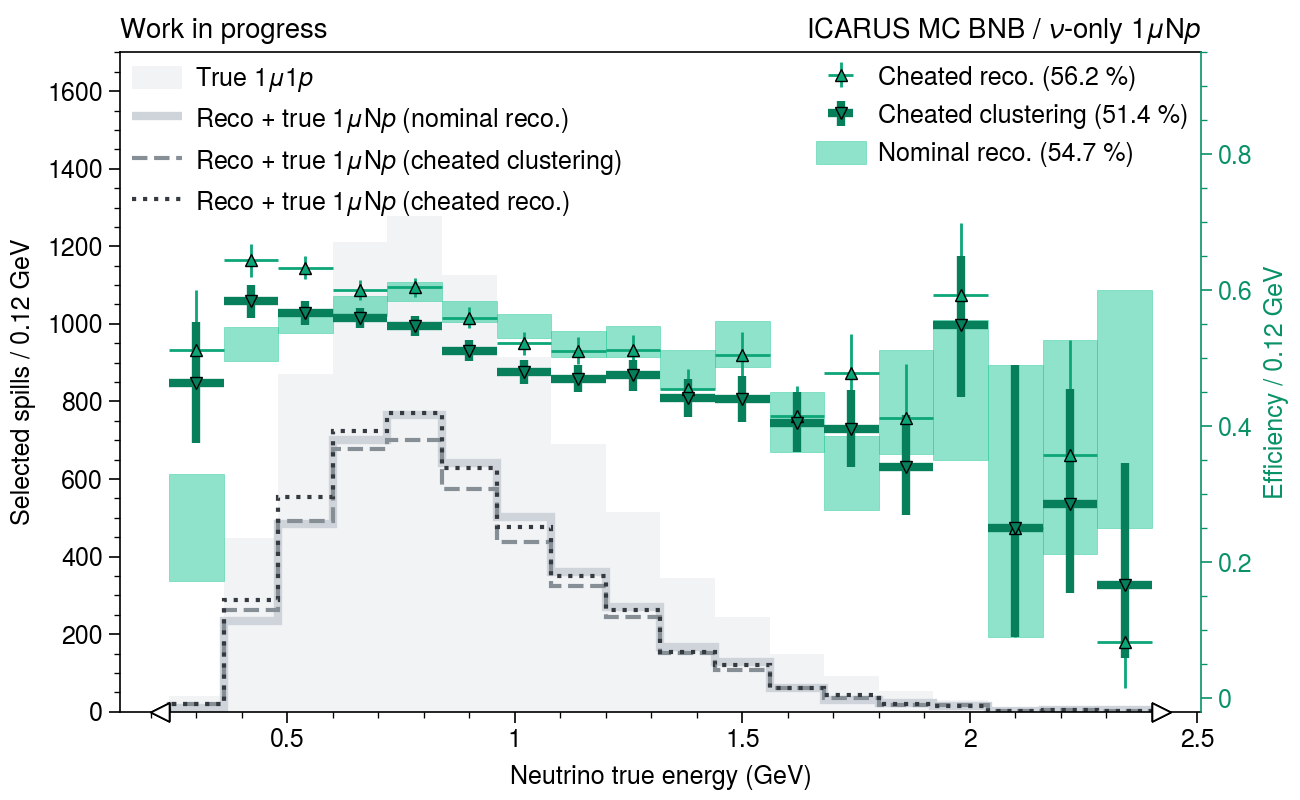

In [154]:
plot_spectra('2k_efficiency_2D_Np.pdf', cheated_loader_mid='cheated_2D_loader')